# Preparation

### Import, constants and functions

In [1]:
import numpy as np
from numpy.random import seed
#seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [4]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")    

In [5]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [6]:
# Load data from the folder
with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/train_dataset_small.npy', 'rb') as f:
    train_dataset = np.load(f)

with open('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/test_dataset_small.npy', 'rb') as f:
    test_dataset = np.load(f)

In [7]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [8]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    432 samples
Test set:     144 samples
Sample dims:  (432, 128, 192, 3)


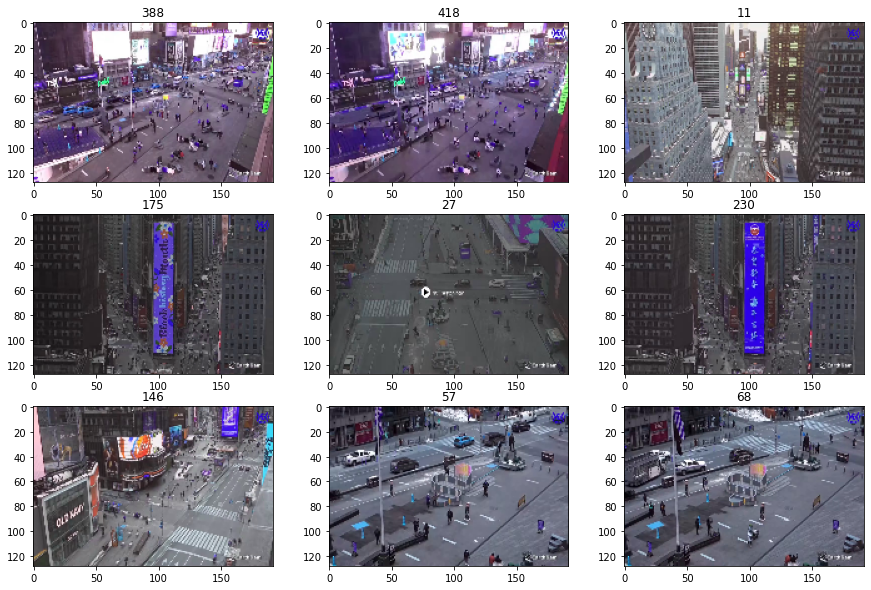

In [9]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [10]:
# Normalization
train_dataset = train_dataset.astype('float32')/255
test_dataset = test_dataset.astype('float32')/255

## Model

###Creating

In [11]:
latent_dim = 5000
filters=(32, 64, 128, 256, 512)



#encoder============================================
inputs = layers.Input(shape=(hight, width, 3))

net = inputs
# loop over the number of filters
for f in filters:
  # apply a CONV => RELU => BN operation
  net = layers.Conv2D(f, (3, 3), padding="same")(net)
  net = layers.LeakyReLU(alpha=0.3)(net)
  net = layers.BatchNormalization(axis=-1)(net)  
  net = layers.MaxPooling2D((2, 2))(net) 
  

latentSize = K.int_shape(net)
net = layers.Flatten()(net)
latent = layers.Dense(latent_dim, activation='relu')(net)

encoder = Model(inputs, latent, name="encoder")



#decoder============================================
latentInputs = layers.Input(latent_dim)
net = layers.Dense(np.prod(latentSize[1:]))(latentInputs)
net = layers.Reshape((latentSize[1], latentSize[2], latentSize[3]))(net)

# loop over our number of filters again, but this time in
# reverse order
for f in filters[::-1]:
  # apply a CONV_TRANSPOSE => RELU => BN operation
  net = layers.Conv2DTranspose(f, (3, 3), padding="same")(net)  
  net = layers.LeakyReLU(alpha=0.3)(net)
  net = layers.BatchNormalization(axis=-1)(net)
  net = layers.UpSampling2D((2, 2))(net)

net = layers.Conv2DTranspose(3, (3, 3), padding="same")(net)
outputs = layers.Activation("sigmoid")(net)

decoder = Model(latentInputs, outputs, name="decoder")



#autoencoder============================================
autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

###Summary

In [12]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 192, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 192, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 192, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 192, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 96, 64)        1849

In [13]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_1 (Dense)             (None, 12288)             61452288  
                                                                 
 reshape (Reshape)           (None, 4, 6, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 6, 512)        2359808   
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 6, 512)         0         
                                                                 
 batch_normalization_5 (Batc  (None, 4, 6, 512)        2048      
 hNormalization)                                           

In [14]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])

###Fit

In [15]:
epochs = 25
batch_size = 16
history = autoencoder.fit(DataGenerator(train_dataset, train_dataset, batch_size),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(DataGenerator(test_dataset, test_dataset, batch_size)))

Epoch 1/25
27/27 [==============================] - 72s 3s/step - loss: 0.0642 - accuracy: 0.3245 - val_loss: 0.1426 - val_accuracy: 0.0792
Epoch 2/25
27/27 [==============================] - 69s 3s/step - loss: 0.0490 - accuracy: 0.4095 - val_loss: 0.1476 - val_accuracy: 0.1419
Epoch 3/25
27/27 [==============================] - 69s 3s/step - loss: 0.0423 - accuracy: 0.4989 - val_loss: 0.0377 - val_accuracy: 0.0804
Epoch 4/25
27/27 [==============================] - 69s 3s/step - loss: 0.0403 - accuracy: 0.5397 - val_loss: 0.0731 - val_accuracy: 0.1625
Epoch 5/25
27/27 [==============================] - 68s 3s/step - loss: 0.0362 - accuracy: 0.5548 - val_loss: 0.0489 - val_accuracy: 0.2413
Epoch 6/25
27/27 [==============================] - 69s 3s/step - loss: 0.0331 - accuracy: 0.5798 - val_loss: 0.0334 - val_accuracy: 0.4009
Epoch 7/25
27/27 [==============================] - 67s 3s/step - loss: 0.0314 - accuracy: 0.6004 - val_loss: 0.0464 - val_accuracy: 0.3898
Epoch 8/25
27/27 [==

Train Acc      0.6203697919845581
Validation Acc 0.6457030773162842


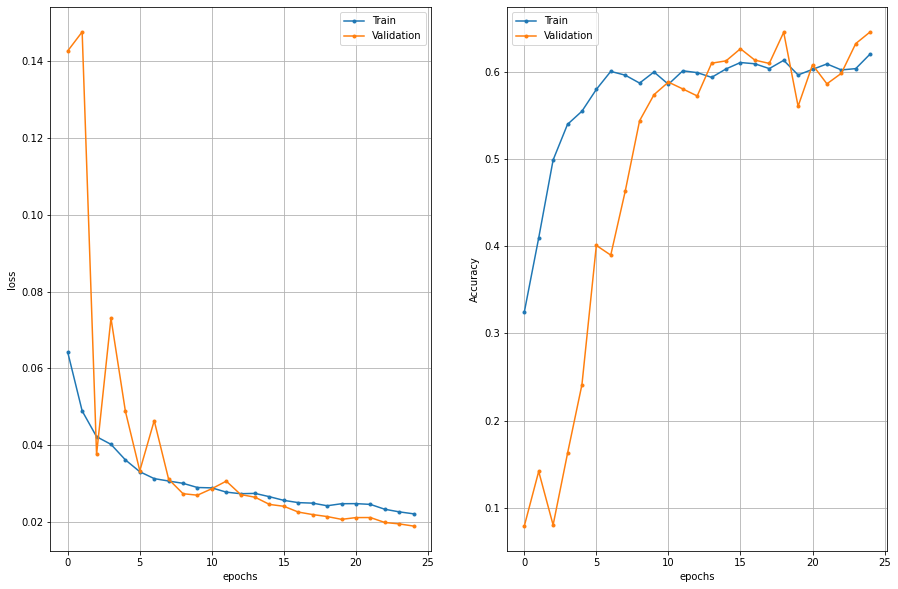

In [16]:
show_results(history)

###Result inspaction

In [17]:
encoded_imgs = encoder(test_dataset).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

#with open('drive/MyDrive/Colab Notebooks/encoded_imgs.npy', 'wb') as f:
#    np.save(f, encoded_imgs)

In [18]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/encoded_imgs.shape[1])

Sample encoded:  (144, 5000)
Sample decoded:  (144, 128, 192, 3)
comression:  14.7456


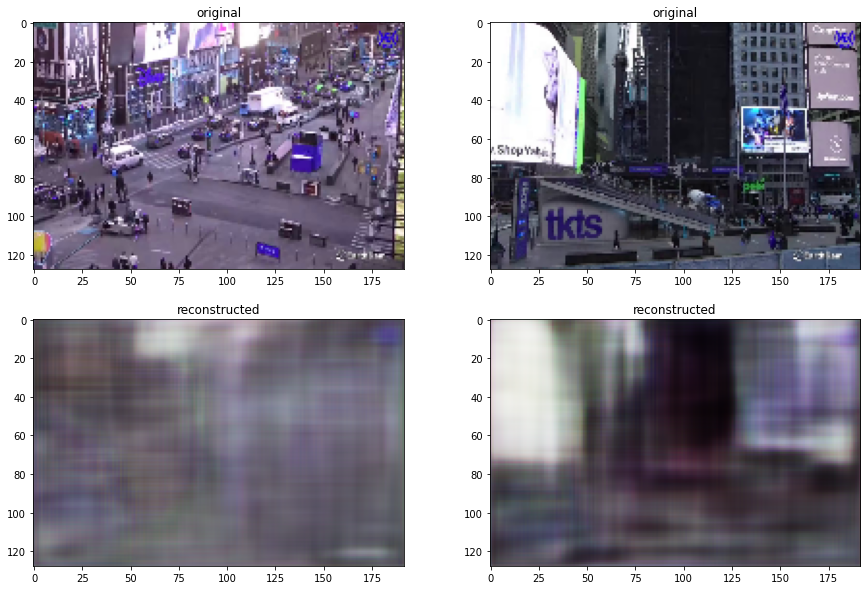

In [19]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)

Sample dims:  (1, 128, 192, 3)


Text(0.5, 1.0, 'reconstructed')

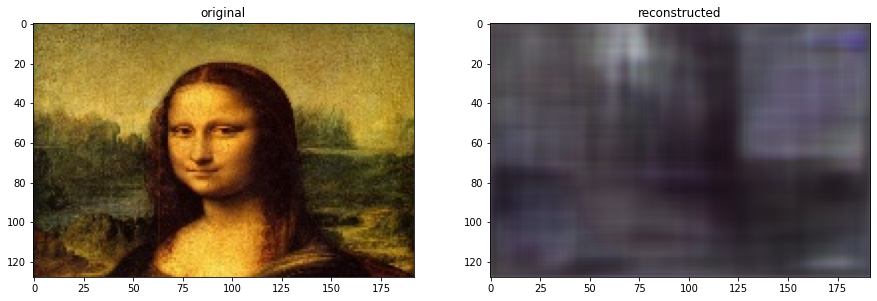

In [20]:
control_Img = cv2.imread('drive/MyDrive/Colab Notebooks/StreetCamera_Data_XX/monolisa.jpg')
control_Img = cv2.cvtColor(control_Img, cv2.COLOR_BGR2RGB)
control_Imgs = np.array([control_Img])

print('Sample dims: ', control_Imgs.shape)

control_Imgs = control_Imgs.astype('float32')/255

control_encoded_imgs = encoder(control_Imgs).numpy()
control_decoded_imgs = decoder(control_encoded_imgs).numpy()

plt.subplot(1,2,1), plt.imshow(control_Imgs[0])
plt.title("original")

plt.subplot(1,2,2), plt.imshow(control_decoded_imgs[0])
plt.title("reconstructed")   